# UNI- MLP Bootstrap TTFS

                                                                                                                                                            
Mode.SNN
[Epoch 1/60]
SNN Testing: loss =     0.01000                          accuracy = 0.00000 
                                                                                                                                                                                          
Mode.SNN
[Epoch 2/60]
SNN Testing: loss =     0.01084 (min =     0.01000)     accuracy = 0.00000 (max = 0.00000) 
                                                                                                                                                                                          
Mode.SNN
[Epoch 3/60]
SNN Testing: loss =     0.00988 (min =     0.01000)     accuracy = 0.00000 (max = 0.00000) 
                                                                                                                                              

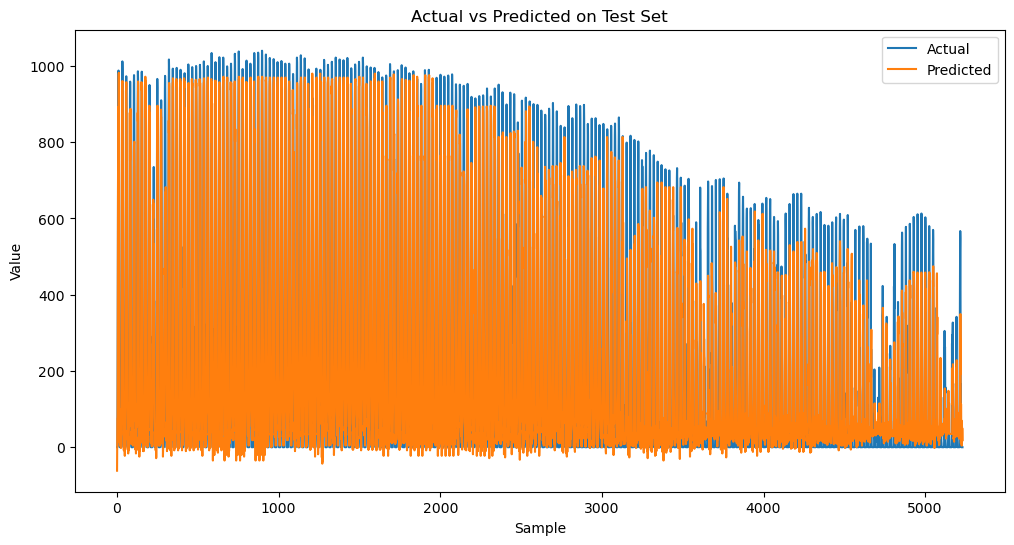

In [21]:
import torch
import pandas as pd
import numpy as np
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
import warnings
import lava.lib.dl.slayer as slayer
import lava.lib.dl.bootstrap as bootstrap
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# ===========================
# 1. Data Preparation
# ===========================

# Suppress deprecated warnings if necessary
warnings.filterwarnings("ignore", category=UserWarning)

def load_univariate_data(file_path, column_index=5, seq_size=24, train_ratio=0.80):
    """
    Loads and preprocesses univariate time series data.

    Returns:
        tuple: Scaled and split training and testing data and targets, and the scaler.
    """
    # Load data
    data = read_csv(file_path, index_col='date')
    data.index.name = 'Date'
    # Convert index to datetime
    data.index = pd.to_datetime(data.index)

    # Sort the DataFrame by the index (date) in ascending order
    data = data.sort_index()

    # Select the desired column (univariate)
    data = data.iloc[:, column_index]  # Adjust column index as needed

    # Drop rows with missing values
    data = data.dropna()
    data = data.astype('float64')

    # Convert the Series to a numpy array and reshape
    data = np.array(data).reshape(-1, 1)

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)

    # Split into training and testing sets
    train_size = int(len(data) * train_ratio)
    train, test = data[0:train_size, :], data[train_size:, :]

    # Convert to sequences
    def to_sequences(dataset, seq_size=24):
        x = []
        y = []
        for i in range(len(dataset) - seq_size):
            window = dataset[i:(i + seq_size), 0]
            x.append(window)
            y.append(dataset[i + seq_size, 0])
        return np.array(x), np.array(y)

    train_X, train_y = to_sequences(train, seq_size)
    test_X, test_y = to_sequences(test, seq_size)

    # Return the scaler for inverse transformation
    return train_X, train_y, test_X, test_y, scaler

# Parameters for data loading
#file_path = 'jordan_pv.csv'  # Replace with your file path
file_path = 'Palestine-pv.csv'  # Replace with your file path

column_index = 5  # Replace with the correct column index for 'Solar Radiation(GHI)'
seq_size = 24  # Number of time steps to look back

# Load and preprocess data
train_X, train_y, test_X, test_y, scaler = load_univariate_data(
    file_path=file_path,
    column_index=column_index,
    seq_size=seq_size,
    train_ratio=0.80
)

# Convert data and labels to PyTorch tensors
train_X = torch.Tensor(train_X)  # Shape: [num_train_samples, seq_size]
train_y = torch.Tensor(train_y).unsqueeze(1)  # Shape: [num_train_samples, 1]
test_X = torch.Tensor(test_X)    # Shape: [num_test_samples, seq_size]
test_y = torch.Tensor(test_y).unsqueeze(1)    # Shape: [num_test_samples, 1]

# Encode the inputs using TTFS encoding
time_steps = 16

def ttfs_encoding(batch, max_time_steps):
    """
    TTFS Encoding without epsilon adjustment.
    """
    spike_times = (1.0 - batch) * (max_time_steps - 1)
    spike_times = spike_times.long()
    return spike_times

def generate_ttfs_spike_trains(spike_times, max_time_steps):
    """
    Generate spike trains with spikes at the spike time.
    """
    batch_size, num_features = spike_times.shape
    spike_trains = torch.zeros(batch_size, num_features, max_time_steps)
    for b in range(batch_size):
        for n in range(num_features):
            t = spike_times[b, n]
            if t >= 0 and t < max_time_steps:
                spike_trains[b, n, t] = 1.0  # Spike at time t
    return spike_trains  # Shape: [batch_size, num_features, time_steps]

# Apply TTFS encoding
train_spike_times = ttfs_encoding(train_X, time_steps)
test_spike_times = ttfs_encoding(test_X, time_steps)
train_X_encoded = generate_ttfs_spike_trains(train_spike_times, time_steps)
test_X_encoded = generate_ttfs_spike_trains(test_spike_times, time_steps)

# Reshape and permute to match expected input shape [N, C, D, H, W]
train_X_encoded = train_X_encoded.unsqueeze(3).unsqueeze(4)  # Shape: [batch_size, num_features, time_steps, 1, 1]
test_X_encoded = test_X_encoded.unsqueeze(3).unsqueeze(4)

# Permute dimensions to [batch_size, channels, depth (time), height, width]
train_X_encoded = train_X_encoded.permute(0, 1, 2, 3, 4)
test_X_encoded = test_X_encoded.permute(0, 1, 2, 3, 4)

# ===========================
# 3. Create DataLoaders
# ===========================

batch_size = 64
training_set = torch.utils.data.TensorDataset(train_X_encoded, train_y)
testing_set = torch.utils.data.TensorDataset(test_X_encoded, test_y)
train_loader = DataLoader(dataset=training_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=testing_set, batch_size=batch_size, shuffle=False)

# ===========================
# 4. Define the Neural Network Architecture
# ===========================

class Network(torch.nn.Module):
    def __init__(self, time_steps=time_steps):
        super(Network, self).__init__()
        self.time_steps = time_steps

        neuron_params = {
            'threshold': 0.5,
            'current_decay': 1,  # Must be 1 to use batchnorm
            'voltage_decay': 0.03,
            'tau_grad': 0.1,
            'scale_grad': 1,
        }
        neuron_params_norm = {
            **neuron_params,
            # 'norm': slayer.neuron.norm.MeanOnlyBatchNorm,
            # 'dropout': slayer.neuron.Dropout(p=0.2),  # Neuron dropout
        }

        self.blocks = torch.nn.ModuleList([
            bootstrap.block.cuba.Input(neuron_params, weight=1, bias=0),  # Input block
            bootstrap.block.cuba.Dense(neuron_params_norm, seq_size, 32),
            bootstrap.block.cuba.Dense(neuron_params_norm, 32, 32),
            bootstrap.block.cuba.Affine(neuron_params, 32, 1),
        ])

    def forward(self, x, mode):
        N, C, D, H, W = x.shape
        x = x.view(N, -1, D)  # Flatten spatial dimensions if necessary
        for idx, (block, m) in enumerate(zip(self.blocks, mode)):
            x = block(x, mode=m)
            # Debugging: print tensor shapes
            # print(f"After block {idx} ({block.__class__.__name__}): {x.shape}")
        return x

# ===========================
# 5. Instantiate Network, Optimizer, and Scheduler
# ===========================

lr = 0.001  # Learning rate
epochs = 60  # Training epochs
trained_folder = 'Trained'
os.makedirs(trained_folder, exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Network().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
stats = slayer.utils.LearningStats()
scheduler = bootstrap.routine.Scheduler()

# ===========================
# 6. Training Loop with Scheduler and Early Stopping
# ===========================

for epoch in range(epochs):
    net.train()
    for i, (input, label) in enumerate(train_loader, 0):
        mode = [bootstrap.Mode.SNN] * len(net.blocks)
        input, label = input.to(device), label.to(device)
        output = net.forward(input, mode)
        rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))
        label = label.to(device)
        loss = F.mse_loss(rate, label)
        stats.training.num_samples += len(label)
        stats.training.loss_sum += loss.cpu().data.item() * input.shape[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'\r[Epoch {epoch+1}/{epochs}] {stats}', end='')

    net.eval()
    with torch.no_grad():
        for i, (input, label) in enumerate(test_loader, 0):
            mode = [bootstrap.Mode.SNN] * len(net.blocks)
            input, label = input.to(device), label.to(device)
            output = net.forward(input, mode)
            rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))
            label = label.to(device)
            loss = F.mse_loss(rate, label)
            stats.testing.num_samples += len(label)
            stats.testing.loss_sum += loss.cpu().data.item() * input.shape[0]
    print(f'\r[Epoch {epoch+1}/{epochs}] {stats}', end='')

    if mode[0] == bootstrap.Mode.SNN:
        scheduler.sync_snn_stat(stats.testing)
        print('\r', ' ' * len(f'\r[Epoch {epoch+1}/{epochs}] {stats}'))
        print(mode[0])
        print(f'[Epoch {epoch+1}/{epochs}]\nSNN Testing: {scheduler.snn_stat}')

        if scheduler.snn_stat.best_loss:
            torch.save(net.state_dict(), trained_folder + '/network.pt')
        scheduler.update_snn_stat()

    stats.update()
    stats.save(trained_folder + '/')

# ===========================
# 7. Evaluation and Metrics Calculation
# ===========================

# Ensure the model is in evaluation mode
net.eval()

all_predictions = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for i, (input, label) in enumerate(test_loader):
        # Set mode to SNN
        mode = [bootstrap.Mode.SNN] * len(net.blocks)

        # Move input and label to the appropriate device
        input = input.to(device)
        label = label.to(device)

        # Forward pass
        output = net(input, mode=mode)

        # Compute the rate as done during training
        rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

        # Move rate and label to CPU and convert to numpy
        rate_np = rate.cpu().numpy()
        label_np = label.cpu().numpy()

        # Accumulate predictions and labels
        all_predictions.append(rate_np)
        all_labels.append(label_np)

# Concatenate all batches
all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Inverse transform the predictions and labels
# Reshape to (-1, 1) for inverse_transform
all_predictions_reshaped = all_predictions.reshape(-1, 1)
all_labels_reshaped = all_labels.reshape(-1, 1)

# Inverse transform
all_predictions_inv = scaler.inverse_transform(all_predictions_reshaped)
all_labels_inv = scaler.inverse_transform(all_labels_reshaped)

# Calculate RMSE and MAE
test_rmse = np.sqrt(mean_squared_error(all_labels_inv, all_predictions_inv))
test_mae = mean_absolute_error(all_labels_inv, all_predictions_inv)

print(f"\nTest RMSE (Unnormalized): {test_rmse:.4f}")
print(f"Test MAE (Unnormalized): {test_mae:.4f}")

# Optionally, plot the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(all_labels_inv, label='Actual')
plt.plot(all_predictions_inv, label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Actual vs Predicted on Test Set')
plt.legend()
plt.show()


# UNI- MLP Bootstrap Sigma Delta 

In [ ]:
import torch
import pandas as pd
import numpy as np
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
import warnings
import lava.lib.dl.slayer as slayer
import lava.lib.dl.bootstrap as bootstrap
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# ===========================
# 1. Data Preparation
# ===========================

# Suppress deprecated warnings if necessary
warnings.filterwarnings("ignore", category=UserWarning)

def load_univariate_data(file_path, column_index=5, seq_size=3, train_ratio=0.80):
    """
    Loads and preprocesses univariate time series data.

    Returns:
        tuple: Scaled and split training and testing data and targets, and the scaler.
    """
    # Load data
    data = read_csv(file_path, index_col='date')
    data.index.name = 'Date'
    # Convert index to datetime
    data.index = pd.to_datetime(data.index)

    # Sort the DataFrame by the index (date) in ascending order
    data = data.sort_index()

    # Select the desired column (univariate)
    data = data.iloc[:, column_index]  # Adjust column index as needed

    # Drop rows with missing values
    data = data.dropna()
    data = data.astype('float64')

    # Convert the Series to a numpy array and reshape
    data = np.array(data).reshape(-1, 1)

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)

    # Split into training and testing sets
    train_size = int(len(data) * train_ratio)
    train, test = data[0:train_size, :], data[train_size:, :]

    # Convert to sequences
    def to_sequences(dataset, seq_size=3):
        x = []
        y = []
        for i in range(len(dataset) - seq_size):
            window = dataset[i:(i + seq_size), 0]
            x.append(window)
            y.append(dataset[i + seq_size, 0])
        return np.array(x), np.array(y)

    train_X, train_y = to_sequences(train, seq_size)
    test_X, test_y = to_sequences(test, seq_size)

    # Return the scaler for inverse transformation
    return train_X, train_y, test_X, test_y, scaler

# Parameters for data loading
#file_path = 'Palestine-pv.csv'  # Replace with your file path
file_path = 'jordan_pv.csv'  # Replace with your file path

column_index = 5  # Replace with the correct column index for 'Solar Radiation(GHI)'
seq_size = 3  # Number of time steps to look back

# Load and preprocess data
train_X, train_y, test_X, test_y, scaler = load_univariate_data(
    file_path=file_path,
    column_index=column_index,
    seq_size=seq_size,
    train_ratio=0.80
)

# Convert data and labels to PyTorch tensors
train_X = torch.Tensor(train_X)  # Shape: [num_train_samples, seq_size]
train_y = torch.Tensor(train_y).unsqueeze(1)  # Shape: [num_train_samples, 1]
test_X = torch.Tensor(test_X)    # Shape: [num_test_samples, seq_size]
test_y = torch.Tensor(test_y).unsqueeze(1)    # Shape: [num_test_samples, 1]

# ===========================
# 2. Sigma-Delta Encoding
# ===========================

time_steps = 16  # Define the number of time steps

def sigma_delta_encoding(batch, time_steps, threshold=0.9):
    """
    Sigma-Delta Encoding: Converts continuous input values into spike trains based on the accumulation of input signals.

    Arguments:
        batch: Tensor of shape [batch_size, num_features]
        time_steps: Number of time steps for encoding
        threshold: Accumulation threshold to emit a spike

    Returns:
        spike_trains: Tensor of shape [batch_size, num_features, 1, 1, time_steps]
    """
    batch_size, num_features = batch.shape
    spike_trains = torch.zeros(batch_size, num_features, 1, 1, time_steps, device=batch.device)
    membrane_potential = torch.zeros(batch_size, num_features, device=batch.device)

    for t in range(time_steps):
        membrane_potential += batch  # Accumulate input
        spikes = (membrane_potential >= threshold).float()
        spike_trains[:, :, 0, 0, t] = spikes  # Assign spikes at current time step
        membrane_potential[spikes.bool()] -= threshold  # Reset membrane potential where spikes occurred

    return spike_trains  # Shape: [batch_size, num_features, 1, 1, time_steps]

def sigma_delta_decoding(output):
    """
    Sigma-Delta Decoding: Decodes the output spike trains into continuous values.

    Arguments:
        output: Tensor of shape [batch_size, 1, D, 1, 1]

    Returns:
        decoded_output: Tensor of shape [batch_size]
    """
    # Sum spikes over the time dimension
    decoded_output = output.sum(dim=2) / output.size(2)  # Sum over time dimension
    decoded_output = decoded_output.squeeze()  # Remove dimensions of size 1
    return decoded_output  # Shape: [batch_size]

# Apply Sigma-Delta encoding
train_X_encoded = sigma_delta_encoding(train_X, time_steps)
test_X_encoded = sigma_delta_encoding(test_X, time_steps)

# Permute dimensions to [batch_size, channels, depth (time), height, width]
train_X_encoded = train_X_encoded.permute(0, 1, 4, 2, 3)
test_X_encoded = test_X_encoded.permute(0, 1, 4, 2, 3)

# ===========================
# 3. Create DataLoaders
# ===========================

batch_size = 64
training_set = torch.utils.data.TensorDataset(train_X_encoded, train_y)
testing_set = torch.utils.data.TensorDataset(test_X_encoded, test_y)
train_loader = DataLoader(dataset=training_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=testing_set, batch_size=batch_size, shuffle=False)

# ===========================
# 4. Define the Neural Network Architecture
# ===========================

class Network(torch.nn.Module):
    def __init__(self, time_steps=time_steps):
        super(Network, self).__init__()
        self.time_steps = time_steps

        neuron_params = {
            'threshold': 0.5,
            'current_decay': 1,  # Must be 1 to use batchnorm
            'voltage_decay': 0.03,
            'tau_grad': 0.1,
            'scale_grad': 1,
        }
        neuron_params_norm = {
            **neuron_params,
            # 'norm': slayer.neuron.norm.MeanOnlyBatchNorm,
            # 'dropout': slayer.neuron.Dropout(p=0.2),  # Neuron dropout
        }

        self.blocks = torch.nn.ModuleList([
            bootstrap.block.cuba.Input(neuron_params, weight=1, bias=0),  # Input block
            bootstrap.block.cuba.Dense(neuron_params_norm, seq_size, 32),
            bootstrap.block.cuba.Dense(neuron_params_norm, 32, 32),
            bootstrap.block.cuba.Affine(neuron_params, 32, 1),
        ])

    def forward(self, x, mode):
        N, C, D, H, W = x.shape
        x = x.view(N, -1, D)  # Flatten spatial dimensions if necessary
        for idx, (block, m) in enumerate(zip(self.blocks, mode)):
            x = block(x, mode=m)
            # Debugging: print tensor shapes
            # print(f"After block {idx} ({block.__class__.__name__}): {x.shape}")
        return x  # Output shape: [batch_size, 1, D, 1, 1]

# ===========================
# 5. Instantiate Network, Optimizer, and Scheduler
# ===========================

lr = 0.001  # Learning rate
epochs = 60  # Training epochs
trained_folder = 'Trained'
os.makedirs(trained_folder, exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Network().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
stats = slayer.utils.LearningStats()
scheduler = bootstrap.routine.Scheduler()

# ===========================
# 6. Training Loop with Scheduler and Early Stopping
# ===========================

for epoch in range(epochs):
    net.train()
    for i, (input, label) in enumerate(train_loader, 0):
        mode = [bootstrap.Mode.SNN] * len(net.blocks)
        input, label = input.to(device), label.to(device).squeeze()
        output = net.forward(input, mode)
        decoded_output = sigma_delta_decoding(output)
        loss = F.mse_loss(decoded_output, label)
        stats.training.num_samples += len(label)
        stats.training.loss_sum += loss.cpu().data.item() * input.shape[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'\r[Epoch {epoch+1}/{epochs}] {stats}', end='')

    net.eval()
    with torch.no_grad():
        for i, (input, label) in enumerate(test_loader, 0):
            mode = [bootstrap.Mode.SNN] * len(net.blocks)
            input, label = input.to(device), label.to(device).squeeze()
            output = net.forward(input, mode)
            decoded_output = sigma_delta_decoding(output)
            loss = F.mse_loss(decoded_output, label)
            stats.testing.num_samples += len(label)
            stats.testing.loss_sum += loss.cpu().data.item() * input.shape[0]
    print(f'\r[Epoch {epoch+1}/{epochs}] {stats}', end='')

    if mode[0] == bootstrap.Mode.SNN:
        scheduler.sync_snn_stat(stats.testing)
        print('\r', ' ' * len(f'\r[Epoch {epoch+1}/{epochs}] {stats}'))
        print(mode[0])
        print(f'[Epoch {epoch+1}/{epochs}]\nSNN Testing: {scheduler.snn_stat}')

        if scheduler.snn_stat.best_loss:
            torch.save(net.state_dict(), trained_folder + '/network.pt')
        scheduler.update_snn_stat()

    stats.update()
    stats.save(trained_folder + '/')

# ===========================
# 7. Evaluation and Metrics Calculation
# ===========================

# Ensure the model is in evaluation mode
net.eval()

all_predictions = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for i, (input, label) in enumerate(test_loader):
        # Set mode to SNN
        mode = [bootstrap.Mode.SNN] * len(net.blocks)

        # Move input and label to the appropriate device
        input = input.to(device)
        label = label.to(device).squeeze()

        # Forward pass
        output = net(input, mode=mode)

        # Compute the decoded output
        decoded_output = sigma_delta_decoding(output)

        # Move decoded output and label to CPU and convert to numpy
        decoded_output_np = decoded_output.cpu().numpy()
        label_np = label.cpu().numpy()

        # Accumulate predictions and labels
        all_predictions.append(decoded_output_np)
        all_labels.append(label_np)

# Concatenate all batches
all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Reshape to (-1, 1) for inverse_transform
all_predictions_reshaped = all_predictions.reshape(-1, 1)
all_labels_reshaped = all_labels.reshape(-1, 1)

# Inverse transform
all_predictions_inv = scaler.inverse_transform(all_predictions_reshaped)
all_labels_inv = scaler.inverse_transform(all_labels_reshaped)

# Calculate RMSE and MAE
test_rmse = np.sqrt(mean_squared_error(all_labels_inv, all_predictions_inv))
test_mae = mean_absolute_error(all_labels_inv, all_predictions_inv)

print(f"\nTest RMSE (Unnormalized): {test_rmse:.4f}")
print(f"Test MAE (Unnormalized): {test_mae:.4f}")

# Optionally, plot the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(all_labels_inv, label='Actual')
plt.plot(all_predictions_inv, label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Actual vs Predicted on Test Set')
plt.legend()
plt.show()


                                                                                                                                                            
Mode.SNN
[Epoch 1/60]
SNN Testing: loss =     0.00427                          accuracy = 0.00000 
                                                                                                                                                                                          
Mode.SNN
[Epoch 2/60]
SNN Testing: loss =     0.00356 (min =     0.00427)     accuracy = 0.00000 (max = 0.00000) 
                                                                                                                                                                                          
Mode.SNN
[Epoch 3/60]
SNN Testing: loss =     0.00348 (min =     0.00356)     accuracy = 0.00000 (max = 0.00000) 
                                                                                                                                              

# UNI- MLP Bootstrap Population

In [ ]:
import torch
import pandas as pd
import numpy as np
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
import warnings
import lava.lib.dl.slayer as slayer
import lava.lib.dl.bootstrap as bootstrap
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import joblib  # For saving and loading the scaler

# ===========================
# 1. Data Preparation
# ===========================

# Suppress deprecated warnings if necessary
warnings.filterwarnings("ignore", category=UserWarning)

def load_univariate_data(file_path, column_index=5, seq_size=3, train_ratio=0.80):
    """
    Loads and preprocesses univariate time series data.

    Returns:
        tuple: Scaled and split training and testing data and targets, and the scaler.
    """
    # Load data
    data = read_csv(file_path, index_col='date')
    data.index.name = 'Date'
    # Convert index to datetime
    data.index = pd.to_datetime(data.index)

    # Sort the DataFrame by the index (date) in ascending order
    data = data.sort_index()

    # Select the desired column (univariate)
    data = data.iloc[:, column_index]  # Adjust column index as needed

    # Drop rows with missing values
    data = data.dropna()
    data = data.astype('float64')

    # Convert the Series to a numpy array and reshape
    data = np.array(data).reshape(-1, 1)

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)

    # Save the scaler for later use
    joblib.dump(scaler, 'scaler.pkl')

    # Split into training and testing sets
    train_size = int(len(data) * train_ratio)
    train, test = data[0:train_size, :], data[train_size:, :]

    # Convert to sequences
    def to_sequences(dataset, seq_size=3):
        x = []
        y = []
        for i in range(len(dataset) - seq_size):
            window = dataset[i:(i + seq_size), 0]
            x.append(window)
            y.append(dataset[i + seq_size, 0])
        return np.array(x), np.array(y)

    train_X, train_y = to_sequences(train, seq_size)
    test_X, test_y = to_sequences(test, seq_size)

    # Return the scaler for inverse transformation
    return train_X, train_y, test_X, test_y, scaler

# Parameters for data loading
file_path = 'Palestine-pv.csv'  # Replace with your file path
column_index = 5  # Replace with the correct column index for 'Solar Radiation(GHI)'
seq_size = 3  # Number of time steps to look back

# Load and preprocess data
train_X, train_y, test_X, test_y, scaler = load_univariate_data(
    file_path=file_path,
    column_index=column_index,
    seq_size=seq_size,
    train_ratio=0.80
)

# Convert data and labels to PyTorch tensors
train_X = torch.Tensor(train_X)  # Shape: [num_train_samples, seq_size]
train_y = torch.Tensor(train_y).unsqueeze(1)  # Shape: [num_train_samples, 1]
test_X = torch.Tensor(test_X)    # Shape: [num_test_samples, seq_size]
test_y = torch.Tensor(test_y).unsqueeze(1)    # Shape: [num_test_samples, 1]

# ===========================
# 2. Population Encoding
# ===========================

time_steps = 16        # Define the number of time steps
num_neurons = 16       # Number of neurons per input feature
threshold_prob = 0.5   # Probability scaling factor

def population_encode(data, num_neurons, min_val, max_val, threshold_prob, time_steps):
    """
    Population Encoding with Temporal Dimension: Converts continuous input values into spike trains over multiple time steps.
    """
    batch_size, num_features = data.shape

    # Define the receptive fields of the neurons
    centers = torch.linspace(min_val, max_val, num_neurons).to(data.device)  # Shape: [num_neurons]
    sigma = (max_val - min_val) / num_neurons  # Width of the tuning curves

    # Expand dimensions for broadcasting
    data = data.unsqueeze(-1)  # Shape: [batch_size, num_features, 1]
    centers = centers.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, num_neurons]

    # Calculate Gaussian firing rates
    rates = torch.exp(-(data - centers) ** 2 / (2 * sigma ** 2))  # Shape: [batch_size, num_features, num_neurons]

    # Generate spikes over time
    rates = rates.unsqueeze(-1).repeat(1, 1, 1, time_steps)  # Shape: [batch_size, num_features, num_neurons, time_steps]
    spikes = torch.bernoulli(rates * threshold_prob)  # Shape: [batch_size, num_features, num_neurons, time_steps]

    # Reshape to match input shape [batch_size, channels, depth (time), height, width]
    # Combine num_features and num_neurons into channels
    spikes = spikes.view(batch_size, num_features * num_neurons, time_steps, 1, 1)

    return spikes

def population_decode(spikes, num_output_neurons, min_val, max_val):
    """
    Population Decoding: Converts spike trains back to continuous values by weighting spikes with their centers.
    """
    # Sum spikes over time
    spikes_sum = spikes.sum(dim=2)  # Sum over time dimension, Shape: [batch_size, num_output_neurons, 1, 1]

    # Remove singleton dimensions
    spikes_sum = spikes_sum.squeeze(-1).squeeze(-1)  # Shape: [batch_size, num_output_neurons]

    # Define the receptive fields of the neurons
    centers = torch.linspace(min_val, max_val, num_output_neurons).to(spikes.device)  # Shape: [num_output_neurons]

    # Decode by weighting the spikes by their receptive field centers and summing
    decoded_values = (spikes_sum * centers).sum(dim=-1)  # Shape: [batch_size]

    # Normalize by the number of spikes to get the average
    normalization_factor = spikes_sum.sum(dim=-1).clamp(min=1)  # Shape: [batch_size]
    decoded_values /= normalization_factor  # Shape: [batch_size]

    return decoded_values  # Shape: [batch_size]

# Apply Population Encoding
min_val = 0.0  # Since data is scaled between 0 and 1
max_val = 1.0

# Note: Adjusting the device to CPU if necessary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_X = train_X.to(device)
test_X = test_X.to(device)

train_X_encoded = population_encode(train_X, num_neurons, min_val, max_val, threshold_prob, time_steps)
test_X_encoded = population_encode(test_X, num_neurons, min_val, max_val, threshold_prob, time_steps)

# ===========================
# 3. Create DataLoaders
# ===========================

batch_size = 64
training_set = torch.utils.data.TensorDataset(train_X_encoded, train_y)
testing_set = torch.utils.data.TensorDataset(test_X_encoded, test_y)
train_loader = DataLoader(dataset=training_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=testing_set, batch_size=batch_size, shuffle=False)

# ===========================
# 4. Define the Neural Network Architecture
# ===========================

class Network(torch.nn.Module):
    def __init__(self, input_channels, num_output_neurons, time_steps=time_steps):
        super(Network, self).__init__()
        self.time_steps = time_steps

        neuron_params = {
            'threshold': 0.5,
            'current_decay': 1,  # Must be 1 to use batchnorm
            'voltage_decay': 0.03,
            'tau_grad': 0.1,
            'scale_grad': 1,
        }
        neuron_params_norm = {
            **neuron_params,
            # 'norm': slayer.neuron.norm.MeanOnlyBatchNorm,
            # 'dropout': slayer.neuron.Dropout(p=0.2),  # Neuron dropout
        }

        self.blocks = torch.nn.ModuleList([
            bootstrap.block.cuba.Input(neuron_params, weight=1, bias=0),  # Input block
            bootstrap.block.cuba.Dense(neuron_params_norm, input_channels, 32),
            bootstrap.block.cuba.Dense(neuron_params_norm, 32, 32),
            bootstrap.block.cuba.Affine(neuron_params, 32, num_output_neurons),
        ])

    def forward(self, x, mode):
        N, C, D, H, W = x.shape
        x = x.view(N, C, D)  # Flatten spatial dimensions if necessary
        for idx, (block, m) in enumerate(zip(self.blocks, mode)):
            x = block(x, mode=m)
            # Debugging: print tensor shapes
            # print(f"After block {idx} ({block.__class__.__name__}): {x.shape}")
        return x  # Output shape: [batch_size, num_output_neurons, D]

# Set input and output parameters
num_features = train_X.shape[1]
input_channels = num_features * num_neurons
num_output_neurons = 16  # Number of neurons for the output encoding (adjust as needed)

# ===========================
# 5. Instantiate Network, Optimizer, and Scheduler
# ===========================

lr = 0.001  # Learning rate
epochs = 60  # Training epochs
trained_folder = 'Trained'
os.makedirs(trained_folder, exist_ok=True)
net = Network(input_channels, num_output_neurons).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
stats = slayer.utils.LearningStats()
scheduler = bootstrap.routine.Scheduler()

# ===========================
# 6. Training Loop with Scheduler and Early Stopping
# ===========================

for epoch in range(epochs):
    net.train()
    for i, (input, label) in enumerate(train_loader, 0):
        mode = [bootstrap.Mode.SNN] * len(net.blocks)
        input, label = input.to(device), label.to(device)
        output = net.forward(input, mode)
        # Decode output spikes to continuous values
        decoded_output = population_decode(output, num_output_neurons, min_val, max_val)
        label = label.squeeze()
        loss = F.mse_loss(decoded_output, label)
        stats.training.num_samples += len(label)
        stats.training.loss_sum += loss.cpu().data.item() * input.shape[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'\r[Epoch {epoch+1}/{epochs}] {stats}', end='')

    net.eval()
    with torch.no_grad():
        for i, (input, label) in enumerate(test_loader, 0):
            mode = [bootstrap.Mode.SNN] * len(net.blocks)
            input, label = input.to(device), label.to(device)
            output = net.forward(input, mode)
            # Decode output spikes to continuous values
            decoded_output = population_decode(output, num_output_neurons, min_val, max_val)
            label = label.squeeze()
            loss = F.mse_loss(decoded_output, label)
            stats.testing.num_samples += len(label)
            stats.testing.loss_sum += loss.cpu().data.item() * input.shape[0]
    print(f'\r[Epoch {epoch+1}/{epochs}] {stats}', end='')

    if mode[0] == bootstrap.Mode.SNN:
        scheduler.sync_snn_stat(stats.testing)
        print('\r', ' ' * len(f'\r[Epoch {epoch+1}/{epochs}] {stats}'))
        print(mode[0])
        print(f'[Epoch {epoch+1}/{epochs}]\nSNN Testing: {scheduler.snn_stat}')

        if scheduler.snn_stat.best_loss:
            torch.save(net.state_dict(), trained_folder + '/network.pt')
        scheduler.update_snn_stat()

    stats.update()
    stats.save(trained_folder + '/')

# ===========================
# 7. Evaluation and Metrics Calculation
# ===========================

# Ensure the model is in evaluation mode
net.eval()

all_predictions = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for i, (input, label) in enumerate(test_loader):
        # Set mode to SNN
        mode = [bootstrap.Mode.SNN] * len(net.blocks)

        # Move input and label to the appropriate device
        input = input.to(device)
        label = label.to(device).squeeze()

        # Forward pass
        output = net(input, mode=mode)

        # Decode output spikes to continuous values
        decoded_output = population_decode(output, num_output_neurons, min_val, max_val)

        # Move decoded output and label to CPU and convert to numpy
        decoded_output_np = decoded_output.cpu().numpy()
        label_np = label.cpu().numpy()

        # Accumulate predictions and labels
        all_predictions.append(decoded_output_np)
        all_labels.append(label_np)

# Concatenate all batches
all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Reshape to (-1, 1) for inverse_transform
all_predictions_reshaped = all_predictions.reshape(-1, 1)
all_labels_reshaped = all_labels.reshape(-1, 1)

# Load the saved scaler
scaler = joblib.load('scaler.pkl')

# Inverse transform
all_predictions_inv = scaler.inverse_transform(all_predictions_reshaped)
all_labels_inv = scaler.inverse_transform(all_labels_reshaped)

# Calculate RMSE and MAE
test_rmse = np.sqrt(mean_squared_error(all_labels_inv, all_predictions_inv))
test_mae = mean_absolute_error(all_labels_inv, all_predictions_inv)

print(f"\nTest RMSE (Unnormalized): {test_rmse:.4f}")
print(f"Test MAE (Unnormalized): {test_mae:.4f}")

# Optionally, plot the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(all_labels_inv, label='Actual')
plt.plot(all_predictions_inv, label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Actual vs Predicted on Test Set')
plt.legend()
plt.show()
